In [108]:
import os
import glob
import numpy as np 
import scanpy as sc
import pandas as pd
import scipy.stats

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

In [150]:
adata_C = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/Chen.MSI.preprocessed.NanoMnT.ManualAnnot.MSI_score_labeled.lvl3.h5ad')
adata_J = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/Joanito.MSI.preprocessed.NanoMnT.ManualAnnot.MSI_score_labeled.lvl3.h5ad')

In [151]:
adata_J = adata_J[adata_J.obs['MSI']=='MSI-H'].copy()
adata_J

AnnData object with n_obs × n_vars = 56548 × 2000
    obs: 'doublet_score', 'predicted_doublet', 'SampleID', 'PatientID', 'BiopsySite', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'Identifier', 'Author_CellType_lvl_1', 'Author_CellType_lvl_2', 'n_genes', 'leiden', 'AvgSTRDiff', 'StdSTRDiff', 'NumSTRLoci', 'MSI', 'Manual_CellType_lvl_1', 'MSI_score', 'MSI_score_z', 'Manual_CellType_lvl_2', 'BiopsySite2', 'Manual_CellType_lvl_3'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'Author_CellType_lvl_1_colors', 'BiopsySite2_colors', 'Manual_CellType_lvl_1_colors', 'Manual_CellType_lvl_2_colors', 'PatientID_colors', 'hvg', 'leiden', 'leiden_colors', 'log1

## Find MSI intensity associated genes across TME cell types

### Chen et al

In [70]:
adata_C = adata_C[~adata_C.obs['Manual_CellType_lvl_3'].isin(['Tumor cell', 'Enterocytes', 'Goblet', 'Intestinal stem cell', 'N/A'])].copy()

In [139]:
dict_PatientID_to_MSI_score = { PatientID : np.mean(edf['MSI_score']) for PatientID, edf in adata_C.obs[adata_C.obs['Manual_CellType_lvl_3']=='Tumor cell'].groupby('PatientID', observed=True)}
dict_PatientID_to_MSI_score = dict(sorted(dict_PatientID_to_MSI_score.items(), key=lambda x:x[1]))
chen_patient_order_by_MSI_intensity = list(dict_PatientID_to_MSI_score.keys())
adata_C.obs['avg_MSI_score'] = [ dict_PatientID_to_MSI_score[PatientID] for PatientID in adata_C.obs['PatientID'] ]

chen_patient_order_by_MSI_intensity

['P18', 'P17', 'P26', 'P15', 'P20', 'P19', 'P22', 'P23', 'P21', 'P04']

In [146]:
for CellType, edf in adata_C.obs.groupby('Manual_CellType_lvl_3', observed=True):
    if CellType == 'N/A': continue
    
    GeneCorrelationResults = list()
    PATH_save = f'/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/Chen.{CellType}_GeneCorrelation.tsv'
    if os.path.exists(PATH_save)==True: continue
    print(CellType, flush=True)

    adata_C_temp = adata_C[adata_C.obs['Manual_CellType_lvl_3']==CellType].copy()
    adata_C_temp = adata_C_temp.raw.to_adata()
    
    minimumCells = int(len(adata_C_temp) * 0.05)
    print(f'\tMinimum cell threshold: {minimumCells}')
    sc.pp.filter_genes(adata_C_temp, min_cells=minimumCells)
    
    sc.pp.normalize_total(adata_C_temp)
    sc.pp.log1p(adata_C_temp,)
    sc.pp.scale(adata_C_temp, max_value=10)

    dict_PatientID_to_indices = { PatientID : list(edf.index) for PatientID, edf in adata_C_temp.obs.reset_index().groupby('PatientID') }
    
    for gene_idx, gene in enumerate(adata_C_temp.var.index):
        
        dict_PatientID_to_AvgExpression = { PatientID : 0 for PatientID in chen_patient_order_by_MSI_intensity }
        for PatientID, indices in dict_PatientID_to_indices.items():
            expression = list()
            for arr_idx in indices:
                expression.append( adata_C_temp.X[arr_idx][gene_idx] ) 
            dict_PatientID_to_AvgExpression[PatientID] = np.mean(expression)
        
        r, pval = scipy.stats.spearmanr( list(dict_PatientID_to_MSI_score.values()), [ dict_PatientID_to_AvgExpression[PID] for PID in dict_PatientID_to_MSI_score.keys() ] )
        GeneCorrelationResults.append( [gene, r, pval] )
            
    GeneCorrelationResults = pd.DataFrame(GeneCorrelationResults, columns=['gene', 'r', 'pval'])
    GeneCorrelationResults['CellType'] = CellType
    GeneCorrelationResults.to_csv(f'/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME/Chen.{CellType}_GeneCorrelation.tsv', sep='\t', index=False)

NK


	Minimum cell threshold: 46


/tmp/ipykernel_246675/4144248359.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dict_PatientID_to_indices = { PatientID : list(edf.index) for PatientID, edf in adata_C_temp.obs.reset_index().groupby('PatientID') }


Naive B
	Minimum cell threshold: 62


/tmp/ipykernel_246675/4144248359.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dict_PatientID_to_indices = { PatientID : list(edf.index) for PatientID, edf in adata_C_temp.obs.reset_index().groupby('PatientID') }


Pericyte
	Minimum cell threshold: 18


/tmp/ipykernel_246675/4144248359.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dict_PatientID_to_indices = { PatientID : list(edf.index) for PatientID, edf in adata_C_temp.obs.reset_index().groupby('PatientID') }


SMC
	Minimum cell threshold: 6


/tmp/ipykernel_246675/4144248359.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dict_PatientID_to_indices = { PatientID : list(edf.index) for PatientID, edf in adata_C_temp.obs.reset_index().groupby('PatientID') }


Tumor cell
	Minimum cell threshold: 685


/tmp/ipykernel_246675/4144248359.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dict_PatientID_to_indices = { PatientID : list(edf.index) for PatientID, edf in adata_C_temp.obs.reset_index().groupby('PatientID') }


cDC
	Minimum cell threshold: 20


/tmp/ipykernel_246675/4144248359.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dict_PatientID_to_indices = { PatientID : list(edf.index) for PatientID, edf in adata_C_temp.obs.reset_index().groupby('PatientID') }


gd T
	Minimum cell threshold: 99


/tmp/ipykernel_246675/4144248359.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dict_PatientID_to_indices = { PatientID : list(edf.index) for PatientID, edf in adata_C_temp.obs.reset_index().groupby('PatientID') }


pDC
	Minimum cell threshold: 5


/tmp/ipykernel_246675/4144248359.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dict_PatientID_to_indices = { PatientID : list(edf.index) for PatientID, edf in adata_C_temp.obs.reset_index().groupby('PatientID') }


### Joanito et al

In [152]:
dict_PatientID_to_MSI_score = { PatientID : np.mean(edf['MSI_score']) for PatientID, edf in adata_J.obs[adata_J.obs['Manual_CellType_lvl_3']=='Tumor cell'].groupby('PatientID', observed=True)}
dict_PatientID_to_MSI_score = dict(sorted(dict_PatientID_to_MSI_score.items(), key=lambda x:x[1]))
joanito_patient_order_by_MSI_intensity = list(dict_PatientID_to_MSI_score.keys())
adata_J.obs['avg_MSI_score'] = [ dict_PatientID_to_MSI_score[PatientID] for PatientID in adata_J.obs['PatientID'] ]

joanito_patient_order_by_MSI_intensity

['CRC2817', 'CRC2783', 'SC035', 'SC044']

In [121]:
adata_J = adata_J[~adata_J.obs['Manual_CellType_lvl_3'].isin(['Tumor cell', 'Enterocytes', 'Goblet', 'Intestinal stem cell', 'N/A'])].copy()

In [153]:
for CellType, edf in adata_J.obs.groupby('Manual_CellType_lvl_3', observed=True):
    if CellType == 'N/A': continue
    
    GeneCorrelationResults = list()
    PATH_save = f'/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/4_TME/Joanito.{CellType}_GeneCorrelation.tsv'
    if os.path.exists(PATH_save)==True: continue
    print(CellType, flush=True)

    adata_J_temp = adata_J[adata_J.obs['Manual_CellType_lvl_3']==CellType].copy()
    adata_J_temp = adata_J_temp.raw.to_adata()
    
    minimumCells = int(len(adata_J_temp) * 0.05)
    print(f'\tMinimum cell threshold: {minimumCells}')
    sc.pp.filter_genes(adata_J_temp, min_cells=minimumCells)
    
    sc.pp.normalize_total(adata_J_temp)
    sc.pp.log1p(adata_J_temp,)
    sc.pp.scale(adata_J_temp, max_value=10)

    dict_PatientID_to_indices = { PatientID : list(edf.index) for PatientID, edf in adata_J_temp.obs.reset_index().groupby('PatientID') }
    
    for gene_idx, gene in enumerate(adata_J_temp.var.index):
        
        dict_PatientID_to_AvgExpression = { PatientID : 0 for PatientID in joanito_patient_order_by_MSI_intensity }
        for PatientID, indices in dict_PatientID_to_indices.items():
            expression = list()
            for arr_idx in indices:
                expression.append( adata_J_temp.X[arr_idx][gene_idx] ) 
            dict_PatientID_to_AvgExpression[PatientID] = np.mean(expression)
        
        r, pval = scipy.stats.spearmanr( list(dict_PatientID_to_MSI_score.values()), [ dict_PatientID_to_AvgExpression[PID] for PID in dict_PatientID_to_MSI_score.keys() ] )
        GeneCorrelationResults.append( [gene, r, pval] )
            
    GeneCorrelationResults = pd.DataFrame(GeneCorrelationResults, columns=['gene', 'r', 'pval'])
    GeneCorrelationResults['CellType'] = CellType
    GeneCorrelationResults.to_csv(PATH_save, sep='\t', index=False)

CD4+ T


	Minimum cell threshold: 666


/tmp/ipykernel_246675/3302019587.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dict_PatientID_to_indices = { PatientID : list(edf.index) for PatientID, edf in adata_J_temp.obs.reset_index().groupby('PatientID') }


CD8+ T
	Minimum cell threshold: 423


/tmp/ipykernel_246675/3302019587.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dict_PatientID_to_indices = { PatientID : list(edf.index) for PatientID, edf in adata_J_temp.obs.reset_index().groupby('PatientID') }


Endothelial
	Minimum cell threshold: 36


/tmp/ipykernel_246675/3302019587.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dict_PatientID_to_indices = { PatientID : list(edf.index) for PatientID, edf in adata_J_temp.obs.reset_index().groupby('PatientID') }


Enterocytes
	Minimum cell threshold: 0


/tmp/ipykernel_246675/3302019587.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dict_PatientID_to_indices = { PatientID : list(edf.index) for PatientID, edf in adata_J_temp.obs.reset_index().groupby('PatientID') }
/tmp/ipykernel_246675/3302019587.py:31: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, pval = scipy.stats.spearmanr( list(dict_PatientID_to_MSI_score.values()), [ dict_PatientID_to_AvgExpression[PID] for PID in dict_PatientID_to_MSI_score.keys() ] )


Fibroblast
	Minimum cell threshold: 188


/tmp/ipykernel_246675/3302019587.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dict_PatientID_to_indices = { PatientID : list(edf.index) for PatientID, edf in adata_J_temp.obs.reset_index().groupby('PatientID') }


GC B
	Minimum cell threshold: 13


/tmp/ipykernel_246675/3302019587.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dict_PatientID_to_indices = { PatientID : list(edf.index) for PatientID, edf in adata_J_temp.obs.reset_index().groupby('PatientID') }


Glial
	Minimum cell threshold: 14


/tmp/ipykernel_246675/3302019587.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dict_PatientID_to_indices = { PatientID : list(edf.index) for PatientID, edf in adata_J_temp.obs.reset_index().groupby('PatientID') }


Goblet
	Minimum cell threshold: 6


/tmp/ipykernel_246675/3302019587.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dict_PatientID_to_indices = { PatientID : list(edf.index) for PatientID, edf in adata_J_temp.obs.reset_index().groupby('PatientID') }


IGHA+ Plasma
	Minimum cell threshold: 245


/tmp/ipykernel_246675/3302019587.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dict_PatientID_to_indices = { PatientID : list(edf.index) for PatientID, edf in adata_J_temp.obs.reset_index().groupby('PatientID') }


IGHG+ Plasma
	Minimum cell threshold: 142


/tmp/ipykernel_246675/3302019587.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dict_PatientID_to_indices = { PatientID : list(edf.index) for PatientID, edf in adata_J_temp.obs.reset_index().groupby('PatientID') }


ILC
	Minimum cell threshold: 14


/tmp/ipykernel_246675/3302019587.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dict_PatientID_to_indices = { PatientID : list(edf.index) for PatientID, edf in adata_J_temp.obs.reset_index().groupby('PatientID') }


Intestinal stem cell
	Minimum cell threshold: 1


/tmp/ipykernel_246675/3302019587.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dict_PatientID_to_indices = { PatientID : list(edf.index) for PatientID, edf in adata_J_temp.obs.reset_index().groupby('PatientID') }


Macrophage
	Minimum cell threshold: 283


/tmp/ipykernel_246675/3302019587.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dict_PatientID_to_indices = { PatientID : list(edf.index) for PatientID, edf in adata_J_temp.obs.reset_index().groupby('PatientID') }


Mast
	Minimum cell threshold: 23


/tmp/ipykernel_246675/3302019587.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dict_PatientID_to_indices = { PatientID : list(edf.index) for PatientID, edf in adata_J_temp.obs.reset_index().groupby('PatientID') }


Memory B
	Minimum cell threshold: 167


/tmp/ipykernel_246675/3302019587.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dict_PatientID_to_indices = { PatientID : list(edf.index) for PatientID, edf in adata_J_temp.obs.reset_index().groupby('PatientID') }


Monocyte
	Minimum cell threshold: 105


/tmp/ipykernel_246675/3302019587.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dict_PatientID_to_indices = { PatientID : list(edf.index) for PatientID, edf in adata_J_temp.obs.reset_index().groupby('PatientID') }


NK
	Minimum cell threshold: 58


/tmp/ipykernel_246675/3302019587.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dict_PatientID_to_indices = { PatientID : list(edf.index) for PatientID, edf in adata_J_temp.obs.reset_index().groupby('PatientID') }


Naive B
	Minimum cell threshold: 150


/tmp/ipykernel_246675/3302019587.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dict_PatientID_to_indices = { PatientID : list(edf.index) for PatientID, edf in adata_J_temp.obs.reset_index().groupby('PatientID') }


Pericyte
	Minimum cell threshold: 47


/tmp/ipykernel_246675/3302019587.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dict_PatientID_to_indices = { PatientID : list(edf.index) for PatientID, edf in adata_J_temp.obs.reset_index().groupby('PatientID') }


SMC
	Minimum cell threshold: 3


/tmp/ipykernel_246675/3302019587.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dict_PatientID_to_indices = { PatientID : list(edf.index) for PatientID, edf in adata_J_temp.obs.reset_index().groupby('PatientID') }


Transit-amplifying cell
	Minimum cell threshold: 10


/tmp/ipykernel_246675/3302019587.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dict_PatientID_to_indices = { PatientID : list(edf.index) for PatientID, edf in adata_J_temp.obs.reset_index().groupby('PatientID') }


Tumor cell
	Minimum cell threshold: 174


/tmp/ipykernel_246675/3302019587.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dict_PatientID_to_indices = { PatientID : list(edf.index) for PatientID, edf in adata_J_temp.obs.reset_index().groupby('PatientID') }


cDC
	Minimum cell threshold: 9


/tmp/ipykernel_246675/3302019587.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dict_PatientID_to_indices = { PatientID : list(edf.index) for PatientID, edf in adata_J_temp.obs.reset_index().groupby('PatientID') }


gd T
	Minimum cell threshold: 21


/tmp/ipykernel_246675/3302019587.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dict_PatientID_to_indices = { PatientID : list(edf.index) for PatientID, edf in adata_J_temp.obs.reset_index().groupby('PatientID') }


pDC
	Minimum cell threshold: 3


/tmp/ipykernel_246675/3302019587.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dict_PatientID_to_indices = { PatientID : list(edf.index) for PatientID, edf in adata_J_temp.obs.reset_index().groupby('PatientID') }


## Intersecting genes

In [154]:
DIR_MSI_associated_genes_TME_C = '/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/4_TME'
DIR_MSI_associated_genes_TME_J = '/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/4_TME'

GeneCorrelationResults_C = list()
for PATH_tsv in glob.glob(f'{DIR_MSI_associated_genes_TME_C}/*GeneCorrelation.tsv'):
    GeneCorrelationResults_C.append( pd.read_csv(PATH_tsv, sep='\t') )
GeneCorrelationResults_C = pd.concat(GeneCorrelationResults_C)

GeneCorrelationResults_J = list()
for PATH_tsv in glob.glob(f'{DIR_MSI_associated_genes_TME_J}/*GeneCorrelation.tsv'):
    GeneCorrelationResults_J.append( pd.read_csv(PATH_tsv, sep='\t') )
GeneCorrelationResults_J = pd.concat(GeneCorrelationResults_J)

In [161]:
GeneCorrelationResults_C_sig = GeneCorrelationResults_C[GeneCorrelationResults_C['pval']<=0.05].copy()
GeneCorrelationResults_J_sig = GeneCorrelationResults_J[GeneCorrelationResults_J['pval']<=0.05].copy()

GeneCorrelationResults_C_sig['dataset'] = 'Chen'
GeneCorrelationResults_J_sig['dataset'] = 'Joanito'

In [183]:
GeneCorrelationResults_sig_combined = pd.concat([GeneCorrelationResults_C_sig, GeneCorrelationResults_J_sig])
GeneCorrelationResults_sig_combined['isPositivelyCorrelated'] = [ bool(r>=0.5) for r in GeneCorrelationResults_sig_combined['r'] ]

for CellType, edf in GeneCorrelationResults_sig_combined.groupby('CellType', observed=True):
    print(CellType)
    dict_dataset_to_genes = { dataset : set([ f'{tup.gene}_{tup.isPositivelyCorrelated}' for tup in edf2.itertuples() ]) for dataset, edf2 in edf.groupby('dataset', observed=True) }
    if len(dict_dataset_to_genes) != 2: continue
    
    interesecting_genes_pos_cor = [ g.split('_')[0] for g in dict_dataset_to_genes['Chen'].intersection(dict_dataset_to_genes['Joanito']) if g.split('_')[1]=='True' ]
    interesecting_genes_neg_cor = [ g.split('_')[0] for g in dict_dataset_to_genes['Chen'].intersection(dict_dataset_to_genes['Joanito']) if g.split('_')[1]=='False' ]

    print(f'\t{len(dict_dataset_to_genes['Chen'])}\t{len(dict_dataset_to_genes['Joanito'])}')
    print(f'\t{len(interesecting_genes_pos_cor)}\t{len(interesecting_genes_neg_cor)}\t{ len(interesecting_genes_pos_cor)+len(interesecting_genes_neg_cor)}')
    break
    

CD4+ T
	783	721
	85	1	86


In [ ]:
smillie

### ORA analsysi 

## Gene set score

In [211]:
adata_J = adata_J.raw.to_adata()
sc.pp.normalize_total(adata_J)
sc.pp.log1p(adata_J)

adata_C = adata_C.raw.to_adata()
sc.pp.normalize_total(adata_C)
sc.pp.log1p(adata_C)

In [217]:
sc.tl.score_genes(adata_C, ['GZMA', 'GZMB', 'GNLY', 'GZMK', 'PRF1',], score_name='Cytotoxicity')
sc.tl.score_genes(adata_J, ['GZMA', 'GZMB', 'GNLY', 'GZMK', 'PRF1',], score_name='Cytotoxicity')

In [226]:
sc.tl.score_genes(adata_C, interesecting_genes_pos_cor, score_name='Cytotoxicity')
sc.tl.score_genes(adata_J, interesecting_genes_pos_cor, score_name='Cytotoxicity')

<Axes: xlabel='PatientID', ylabel='Cytotoxicity'>

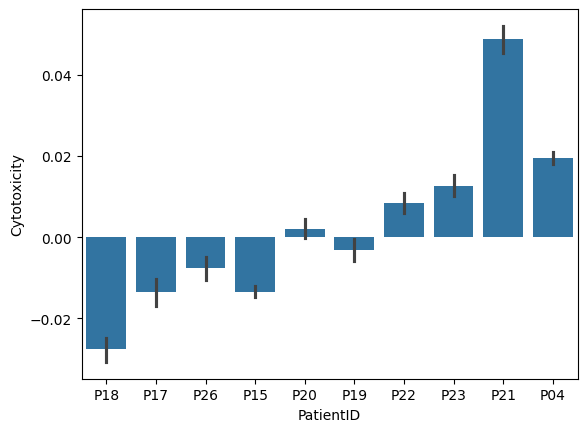

In [229]:
sns.barplot(data=adata_C.obs[adata_C.obs['Manual_CellType_lvl_3']=='CD4+ T'], 
             y='Cytotoxicity', x='PatientID', order=chen_patient_order_by_MSI_intensity, )

<Axes: xlabel='PatientID', ylabel='Cytotoxicity'>

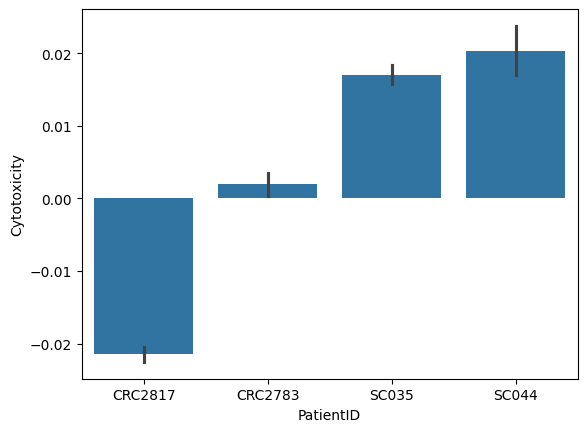

In [230]:
sns.barplot(data=adata_J.obs[adata_J.obs['Manual_CellType_lvl_3']=='CD4+ T'], 
             y='Cytotoxicity', x='PatientID', order=joanito_patient_order_by_MSI_intensity)

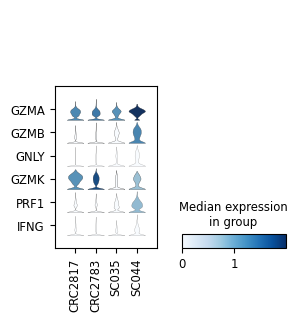

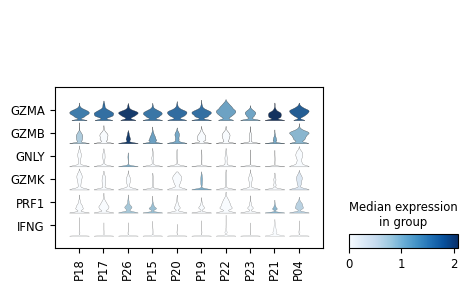

In [216]:
sc


sc.pl.stacked_violin(adata_J[adata_J.obs['Manual_CellType_lvl_3']=='CD8+ T'], 
              var_names=['GZMA', 'GZMB', 'GNLY', 'GZMK', 'PRF1', 'IFNG'], 
              groupby='PatientID', 
              categories_order=joanito_patient_order_by_MSI_intensity, swap_axes=True,)

sc.pl.stacked_violin(adata_C[adata_C.obs['Manual_CellType_lvl_3']=='CD8+ T'], 
              var_names=['GZMA', 'GZMB', 'GNLY', 'GZMK', 'PRF1', 'IFNG'], 
              groupby='PatientID', 
              categories_order=chen_patient_order_by_MSI_intensity, swap_axes=True,)